# Queue

In [1]:
import os
import sys

sys.path.append("../")

In [2]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
from torchviz import make_dot

from src.ml.sinkhorn import pot_sinkhorn, SinkhornValue

In [3]:
sns.set(style="whitegrid")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset generation

In [5]:
n_features = 512
n_clusters = 128
batch_size = 32
n_samples = 2000

In [6]:
class ToyDataset(Dataset):
    def __init__(self, n_features, n_clusters, n_samples):
        self.n_features = n_features
        self.n_clusters = n_clusters
        self.n_samples = n_samples
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_true[idx]
    
    def plot(self):
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5, 5)
        )

        sns.scatterplot(  # plot first 2 components
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=map(str, self.y_true),
            ax=ax,
            legend=False
        )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title("Clusters visualization")

        return fig


class BlobsDataset(ToyDataset):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
    """
    def __init__(self, n_features, n_clusters, n_samples):
        super().__init__(n_features, n_clusters, n_samples)
        
        X, y_true = make_blobs(
            n_samples=n_samples,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=.8,
            random_state=0
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)

In [7]:
dataset = BlobsDataset(n_features, n_clusters, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Model definition

In [8]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )
    
    def forward(self, inputs):
        mlp_out = self.mlp(inputs)
        # mlp_out = nn.functional.normalize(mlp_out)  # TODO: In Caron et al. there is normalization here
        softmax_out = nn.LogSoftmax(dim=1)(mlp_out)
        
        return softmax_out

## Queue implementation

- [x] stored_M (= previous batchs dans la queue)
- [x] M = current batch
- [x] tu rajoutes stored_M comme argument supplementaire à SinkhornValueFunc
- [x] sinkhorn est execute sur M_full = concatenation de M et stored_M
- [x] puis dans SinkhornValue tu implemente la logique de storer les M quand tu call la fonction, avec une logique de queue FIFO 
- [x] et pas besoin d'utiliser une queue pour cela, juste un tensor me semble suffisant, juste quand tu arrives à la limite de taille, pour inserer le nouveau batch, tu "roll" le tensor


In [9]:
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)

In [10]:
stored_M = torch.Tensor()   # tensor acts as queue
max_n_batches_in_queue = 2  # max number of batches in queue

for batch_ix, (inputs, labels) in enumerate(dataloader):
    # M is model output
    M = model(nn.functional.normalize(inputs))
    
    #################
    # Sinkhorn step #
    #################
    M_concat = torch.cat([M, stored_M])
    
    # Compute marginals
    a = torch.ones(M_concat.shape[0])
    b = torch.ones(M_concat.shape[1]) * (M.shape[0] / M.shape[1])
    
    # Compute sinkhorn
    P = pot_sinkhorn(M_concat, a, b, epsilon=0.1, method="sinkhorn_log")

    ################ 
    # Update queue #
    ################
    
    if max_n_batches_in_queue > 0:
        # Update stored M
        n_batches_in_queue = stored_M.shape[0] / batch_size
        if  n_batches_in_queue < max_n_batches_in_queue:
            # Append current batch to previous batches
            stored_M = M_concat
        else:
            # Roll stored M, older batch comes first, replace it with M
            stored_M = torch.roll(stored_M, batch_size, 0)  # roll, first batch is the oldest
            stored_M[:batch_size, :] = M                    # update first batch with new one
    
    # Print for debug
    print("Batch {0}: {1}".format(batch_ix, stored_M.shape))
    
    if batch_ix == 10:
        break

/Users/eric/Code/virtualenvs/data-science/lib/python3.7/site-packages/ot/bregman.py:723: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Batch 0: torch.Size([32, 128])
Batch 1: torch.Size([64, 128])
Batch 2: torch.Size([64, 128])
Batch 3: torch.Size([64, 128])
Batch 4: torch.Size([64, 128])
Batch 5: torch.Size([64, 128])
Batch 6: torch.Size([64, 128])
Batch 7: torch.Size([64, 128])
Batch 8: torch.Size([64, 128])
Batch 9: torch.Size([64, 128])
Batch 10: torch.Size([64, 128])


## Queue integration

In [20]:
# Define model
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)
assert model.mlp[0].in_features == n_features
assert model.mlp[-1].out_features == n_clusters


# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


# Define loss
SV = SinkhornValue(
    epsilon=.2,
    solver=pot_sinkhorn,
    max_n_batches_in_queue=2,
    method="sinkhorn_log",
    numItermax=100,
    warn=True
)
assert SV.solver == pot_sinkhorn
assert SV.solver_options.get("method") == "sinkhorn_log"
assert SV.solver_options.get("numItermax") == 100
assert SV.solver_options.get("warn") == True
assert isinstance(SV.stored_M, torch.Tensor)
assert SV.stored_M.shape[0] == 0


# Input data
X, y = next(iter(dataloader))
X_norm = nn.functional.normalize(X)
assert X_norm.shape == (batch_size, n_features)
assert round(torch.norm(X_norm[1]).item(), ndigits=4) == 1.
assert y.shape[0] == batch_size


# Forward pass
optimizer.zero_grad()
M = model(X_norm)
assert M.shape == (batch_size, n_clusters)
assert all(torch.round(torch.exp(M).sum(axis=1)) == 1.)
assert torch.exp(M).min() >= 0
assert torch.exp(M).max() <= 1

In [21]:
SV = SinkhornValue(
    epsilon=0.1,
    solver=pot_sinkhorn,
    max_n_batches_in_queue=4,
    stopThr=1e-02,
    method="sinkhorn_log",
    # numItermax=400
)

for epoch in range(3):
    for batch_ix, (inputs, labels) in enumerate(dataloader):
        outputs = model(inputs)

        loss = SV(-outputs)
        
        if SV.max_n_batches_in_queue > 0:
            SV.update_queue(-outputs)

        if not SV.queue_is_full:
            continue

        loss.backward()
        optimizer.step()

        print(loss)

        if batch_ix == 15:
            break

tensor(0.6497, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6199, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5766, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5865, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6387, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6413, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6322, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6133, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5965, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5891, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6515, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5884, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6068, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6005, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.6343, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5929, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5604, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.5327, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.4843, grad_fn=<SinkhornValueFuncBackward>)
tensor(0.491

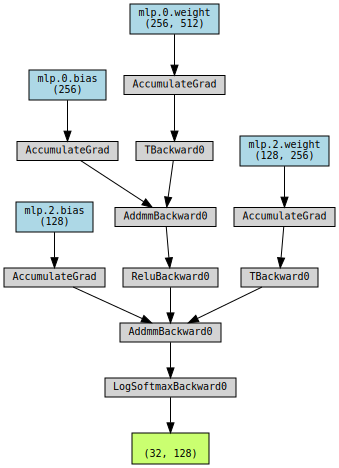

In [15]:
# computational graph
make_dot(M, params=dict(list(model.named_parameters())))